In [97]:
%%capture 
%load_ext autoreload
%autoreload 2
%reset -f


In [98]:
import functions as fn
import pandas as pd
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
import os
import re

In [99]:
path_to_folder = 'data/Alken-7April/'
name = 'experiment1'
experiment_df = pd.read_csv(path_to_folder+name+'_ExG.csv')
marker_df = pd.read_csv(path_to_folder+name+'_Marker.csv')

# combine them together and sort by timestamp
merged_df = pd.concat([experiment_df, marker_df])
merged_df = merged_df.sort_values(by='TimeStamp', ascending=True)

# remove the first row, which is a duplicate
merged_df = merged_df.iloc[1:]
# if values are missing, fill them with previous value
merged_df = merged_df.fillna(method='ffill')
merged_df

,TimeStamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,Code
0,3981.4490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,resume
1,3981.4529,6356.91,2503.11,15325.12,22859.62,18520.55,10749.82,4548.31,9435.46,resume
2,3981.4569,6354.76,2502.16,15322.50,22857.43,18520.55,10751.15,4548.98,9433.32,resume
3,3981.4609,6340.55,2490.52,15308.91,22844.84,18507.82,10747.20,4541.64,9427.60,resume
4,3981.4649,6344.61,2496.53,15315.73,22847.99,18512.35,10757.73,4547.50,9438.09,resume
...,...,...,...,...,...,...,...,...,...,...
38155,4133.9214,6558.09,2579.50,15954.88,22694.64,18270.69,10369.73,4617.60,9192.28,end
38156,4133.9254,6540.01,2565.96,15938.24,22665.65,18248.85,10354.66,4603.82,9179.55,end
38157,4133.9294,6544.40,2569.68,15941.14,22673.85,18256.00,10363.15,4609.87,9186.65,end
38158,4133.9334,6540.59,2570.06,15944.82,22666.36,18251.61,10370.78,4609.16,9190.70,end


In [100]:
epochs = []
start_index = -1
start = False

for index in range(len(merged_df['Code'])):
    ind = merged_df.iloc[index]
    value = ind['Code']
    
    if 'start' in value: pass
    elif 'end' in value: break

    elif 'resume' in value and start_index == -1:
        start_index = index
        start = True

    elif 'pause' in value and start == True:
        epochs.append(merged_df[start_index:index+1])
        start_index = -1
        start = False

epochs[0] = epochs[0].iloc[1:]

In [101]:
concat_nr = 3 
concat_folder = [[] for _ in range(concat_nr)]

# Iterate through the epochs and add them to the appropriate dataframe
for i in range(len(epochs)):
    epoch = epochs[i].iloc[:, :-1]
    index = i % concat_nr
    concat_folder[index].append(epoch)

In [102]:
def get_averaged_epochs(concat):
    min_len = min(len(epoch) for epoch in concat)
    num_epochs = len(concat)
    num_channels = concat[0].shape[1]

    # Initialize an empty array
    array_one = np.zeros((len(concat), min_len, concat[0].shape[1]))

    # Fill the array with the values from the epochs
    for i in range(len(concat)):
        array_one[i] = concat[i].iloc[:min_len, :]
    
    # # Perform matrix addition
    avg_array = array_one[0]
    for array in array_one[1:]:
        np.add(avg_array, array,avg_array)

    # Convert to a numpy array
    array_one = np.array(avg_array)

    # divide each element by the number of epochs
    array_one = array_one/num_epochs

    # round to 4 decimal places
    array_one = np.round(array_one, 4)

    avg_epoch_df = pd.DataFrame(array_one, columns=concat[0].columns)
    return avg_epoch_df

avg_folder = []
for con in concat_folder:
    avg_folder.append(get_averaged_epochs(con))

In [103]:
def write_csv(path_to_folder,extra_folder, name, experiment_name, df):
    path = f"{path_to_folder}/{extra_folder}/{name}{experiment_name}_ExG.csv"
    df.to_csv(path)
    df = pd.read_csv(path)
    df = df.drop(df.columns[0], axis=1)
    df.to_csv(path, index=False)

for index in range(0,len(avg_folder)):
    write_csv(path_to_folder,'epochs', 'avg_epoch_'+str(index)+'_', name, avg_folder[index])

In [113]:
for index in range(0,len(concat_folder)):
    # concatanate the epochs in one np array
    con = concat_folder[index]
    concat = np.concatenate(con, axis=0)
    concat = pd.DataFrame(concat, columns=con[0].columns)
    write_csv(path_to_folder,'epochs', 'concat_epoch_'+str(index)+'_', name, concat)

## **Analyse the EEG Data and set the Global Variables**

In [104]:
chan_name = ['PO3','POz','PO4', 'PO7', 'O1', 'Oz', 'O2', 'PO8']
fs, lf, hf = 250, 2, 30 #Hz

target_freq = [7.5]
eeg_data = fn.process_folder(path_to_folder+'epochs/', chan_name, target_freq=target_freq, hf=hf, lf=lf, epoch_length=6)

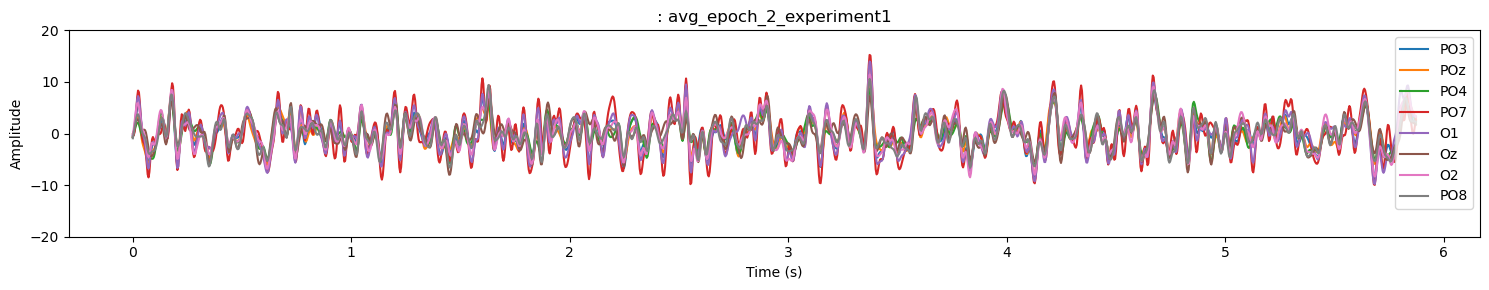

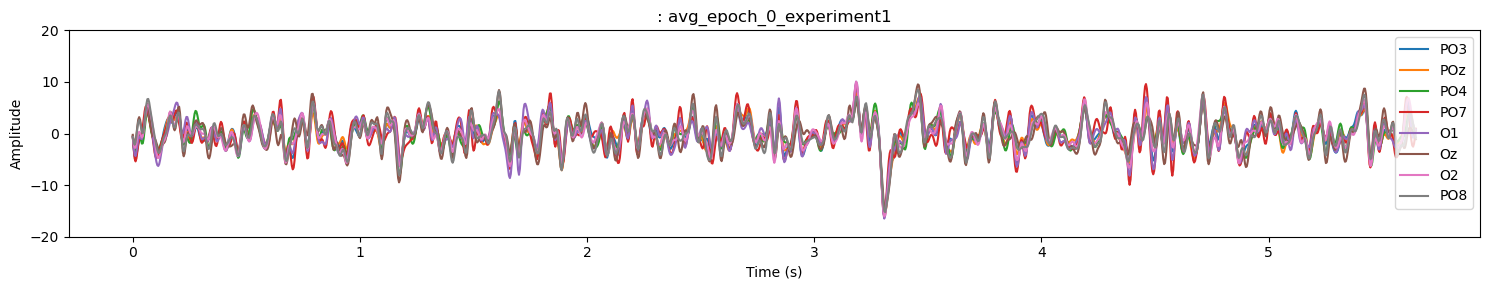

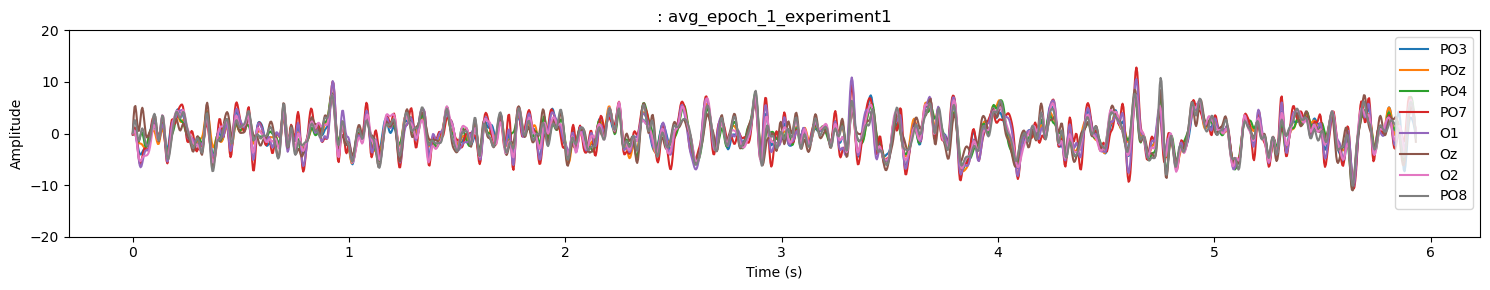

In [109]:
for eeg in eeg_data:
    fn.amplitude_plot(eeg.filtered_signal, chan_name, title=(eeg.title),lim=20)

/Users/alken/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 5000 is greater than input length  = 1469, using nperseg = 1469
  warnings.warn('nperseg = {0:d} is greater than input length '


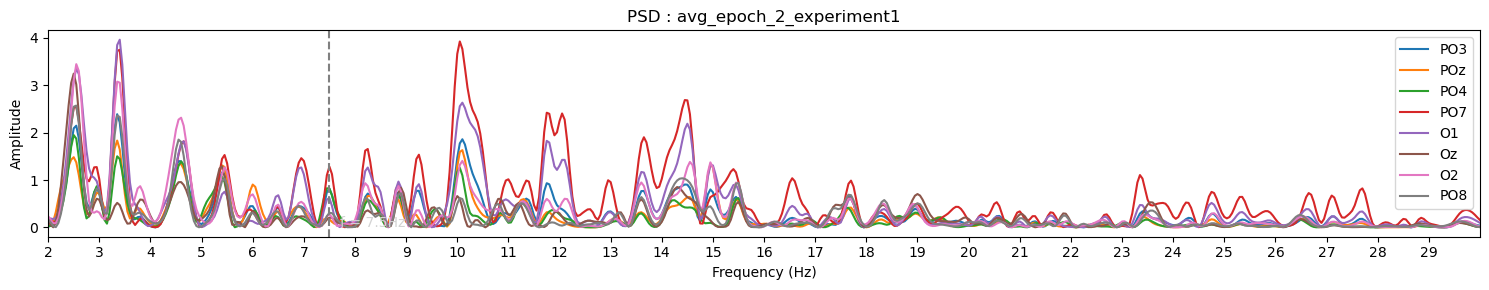

/Users/alken/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 5000 is greater than input length  = 1413, using nperseg = 1413
  warnings.warn('nperseg = {0:d} is greater than input length '


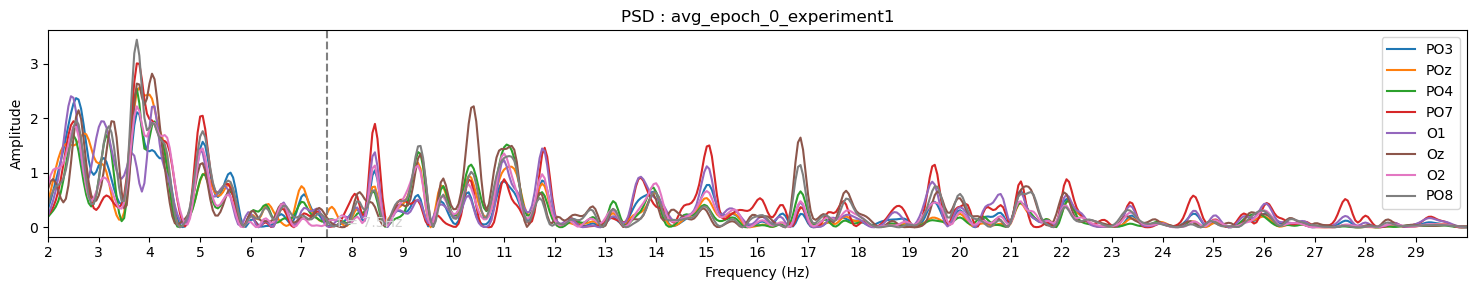

/Users/alken/miniconda3/envs/thesis/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:2014: UserWarning: nperseg = 5000 is greater than input length  = 1484, using nperseg = 1484
  warnings.warn('nperseg = {0:d} is greater than input length '


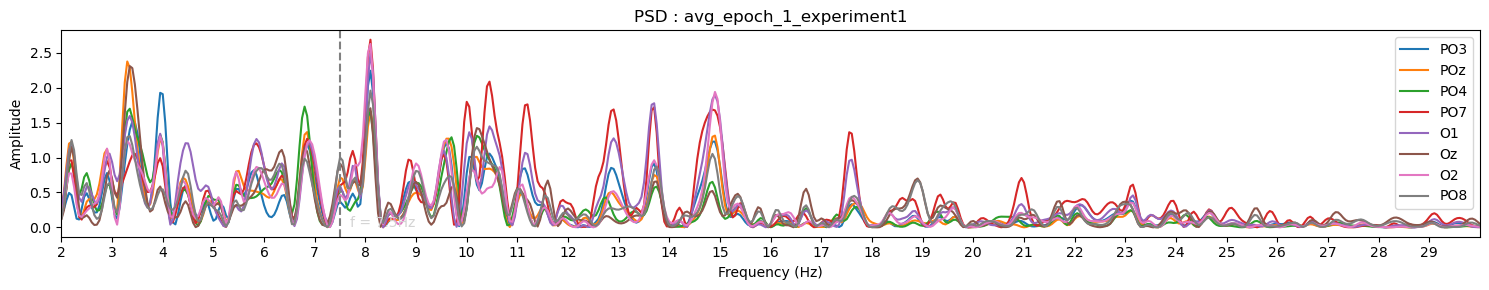

In [110]:
for eeg in eeg_data:
    fn.new_psd_plot(eeg, chan_name, nperseg=20, nfft=20,fig_x=15,fig_y=3, xmin=lf, xlim=30)